# Accelerating Dataframe workflows
### Devin Burke

In [ ]:
%env LC_ALL=C.UTF-8
%env LANG=C.UTF-8

# Table of Contents

- [1. Primer: Sparsity, Density, and CSR](#primer-sparsity-density-and-csr)
  - [Sparsity vs Density](#primer-sparsity-density-and-csr)
  - [Dense vs Sparse Memory Intuition](#dense-vs.-sparse-in-memory)
  - [What CSR Actually Looks Like](#what-csr-actually-looks-like)
  - [Why CSR is Fast for Rows but Slower for Columns](#why-csr-is-fast-for-row-operations)
  - [Common Pitfalls & Safer Alternatives](#common-pitfalls)

- [2. Tools to Find Bottlenecks](#tools-to-find-bottlenecks---measuring-before-optimizing)
  - [Inspecting Matrix Memory Footprint](#tools-to-find-bottlenecks---measuring-before-optimizing)
  - [Timing QC Metrics](#tools-to-find-bottlenecks---measuring-before-optimizing)
  - [Row-wise Scaling Example (Mito Fractions)](#tools-to-find-bottlenecks---measuring-before-optimizing)
  - [The Dangers of Densification](#tools-to-find-bottlenecks---measuring-before-optimizing)
  - [Takeaways from Bottleneck Profiling](#tools-to-find-bottlenecks---measuring-before-optimizing)

- [3. Vectorization](#vectorization)
  - [Primer: What is Vectorization](#vectorization)
  - [Loop vs Vectorized Reductions](#vectorization)
  - [Elementwise Ops on Sparse `.data`](#vectorization)
  - [Broadcasting Safely for Normalization](#vectorization)
  - [Fuse Passes to Reuse Intermediates](#vectorization)
  - [Scaling Curve: Vectorized vs Loop](#vectorization)

- [4. Sparsity-Savvy Ops](#sparsity-savvy-ops)
  - [Counting Genes per Cell: getnnz vs Boolean](#sparsity-savvy-ops)
  - [Column Sums: CSR vs CSC](#sparsit--savvy-ops)
  - [Batching Column Ops](#sparsity-savvy-ops)
  - [Anti-Pattern: Densification via NumPy](#sparsity-savvy-ops)

- [5. CPU Micro-Optimizations](#cpu-micro-optimizations)
  - [Dtype Discipline](#cpu-micro-optimizations)
  - [Row Normalization: Diag vs In-Place](#cpu-micro-optimizations)
  - [Numba for Custom Transforms](#cpu-micro-optimizations)
  - [Block/Tile Processing](#cpu-micro-optimizations)

- [6. When (and How) to Use the GPU](#when-and-how-to-use-the-gpu)
  - [CuPy Basics](#when-and-how-to-use-the-gpu)
  - [CuPy Sparse CSR](#when-and-how-to-use-the-gpu)
  - [RAPIDS cuDF / cuML](#when-and-how-to-use-the-gpu)
  - [RAPIDS Single-Cell End-to-End Pipeline](#when-and-how-to-use-the-gpu)
  - [CPU vs GPU Timing Comparison](#when-and-how-to-use-the-gpu)

- [7. Hybrid Pipelines](#hybrid-pipelines)
  - [CPU for Preprocessing](#hybrid-pipelines)
  - [GPU for Linear Algebra & Graphs](#hybrid-pipelines)
  - [Split-Pipeline Pattern](#hybrid-pipelines)

- [8. Emerging Runtimes & Tools](#emerging-tools)
  - [GPU-Native Frameworks](#emerging-tools)
  - [Scalable Array & Storage Backends](#emerging-tools)
  - [CPU Accelerators](#emerging-tools)
  - [Cluster & Distributed Execution](#emerging-tools)
  - [Where Things Are Heading](#emerging-tools)


In [ ]:
# 1) Uninstall only the conflicting RAPIDS bits (keep it minimal)
!pip uninstall -y cugraph cugraph-cu12 cuml cuml-cu12 rmm rmm-cu12 pylibraft-cu12 pylibcugraph-cu12
# 2) Reinstall a coherent RAPIDS 24.10 set that your Colab already uses
!pip install \
  "rmm-cu12==24.10.*" \
  "pylibraft-cu12==24.10.*" \
  "pylibcugraph-cu12==24.10.*" \
  "cuml-cu12==24.10.*" \
  "cugraph-cu12==24.10.*" \
  --extra-index-url=https://pypi.nvidia.com -U --quiet
# 3) Arrow must be <20 for these RAPIDS wheels
!pip install "pyarrow<20" --upgrade --force-reinstall --quiet
# 4) Print what we actually have now (versions)
import sys, subprocess

print("Python:", sys.version)
for pkg in [
    "cudf-cu12","cuml-cu12","cugraph-cu12",
    "rmm-cu12","pylibraft-cu12","pylibcugraph-cu12",
    "pyarrow","cupy-cuda12x","cuda-python"
]:
    try:
        out = subprocess.check_output([sys.executable,"-m","pip","show",pkg], text=True)
        ver = next((l.split(":",1)[1].strip() for l in out.splitlines() if l.startswith("Version:")), "unknown")
        print(f"{pkg}: {ver}")
    except subprocess.CalledProcessError:
        print(f"{pkg}: not installed")


In [ ]:
try:
    import rmm, cudf, cuml, cugraph
    import pyarrow as pa
    print("Imports OK:",
          getattr(cudf, "__version__", "?"),
          getattr(cuml, "__version__", "?"),
          getattr(cugraph, "__version__", "?"),
          pa.__version__)
except Exception as e:
    import traceback, sys
    print("Import failed:")
    traceback.print_exc(limit=2, file=sys.stdout)


Imports OK: 24.10.01 24.10.00 24.10.00 19.0.1


In [ ]:
!pip install "rapids-singlecell==0.13.1" "scanpy>=1.10,<1.12" "anndata>=0.10,<0.12" "igraph" "leidenalg" "pyarrow<20" --upgrade-strategy only-if-needed -q

In [ ]:
import scanpy as sc, anndata, pandas as pd, numpy as np, scipy as sp
import rmm, cudf, cuml, cugraph, rapids_singlecell as rsc
import cupy as cp

print("RAPIDS:", getattr(cudf, "__version__", "?"), getattr(cuml, "__version__", "?"), getattr(cugraph, "__version__", "?"))
print("rsc:", rsc.__version__)
print("scanpy:", sc.__version__)
print("anndata:", anndata.__version__)
print("pandas/numpy/scipy:", pd.__version__, np.__version__, sp.__version__)
print("cupy:", cp.__version__)

import scanpy as sc
import pandas as pd
import numpy as np
import scipy as sp
import time, warnings
import rapids_singlecell as rsc


In [ ]:
!wget https://cf.10xgenomics.com/samples/cell-exp/9.0.0/320k_Human_PBMCs_Sub_Pool_16-plex_GEM-X_FLEX_PBMC_BC1-16/320k_Human_PBMCs_Sub_Pool_16-plex_GEM-X_FLEX_PBMC_BC1-16_count_sample_filtered_feature_bc_matrix.h5

--2025-08-20 19:56:49--  https://cf.10xgenomics.com/samples/cell-exp/9.0.0/320k_Human_PBMCs_Sub_Pool_16-plex_GEM-X_FLEX_PBMC_BC1-16/320k_Human_PBMCs_Sub_Pool_16-plex_GEM-X_FLEX_PBMC_BC1-16_count_sample_filtered_feature_bc_matrix.h5
Resolving cf.10xgenomics.com (cf.10xgenomics.com)... 104.18.1.173, 104.18.0.173, 2606:4700::6812:1ad, ...
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|104.18.1.173|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1187383220 (1.1G) [application/x-hdf5]
Saving to: ‘320k_Human_PBMCs_Sub_Pool_16-plex_GEM-X_FLEX_PBMC_BC1-16_count_sample_filtered_feature_bc_matrix.h5’

320k_Human_PBMCs_Su 100%[===================>]   1.11G  20.2MB/s    in 49s     

2025-08-20 19:57:39 (23.2 MB/s) - ‘320k_Human_PBMCs_Sub_Pool_16-plex_GEM-X_FLEX_PBMC_BC1-16_count_sample_filtered_feature_bc_matrix.h5’ saved [1187383220/1187383220]



# 1. Primer: Sparsity, Density, and CSR


## Sparsity vs. Density

Density = fraction of non-zeros

Sparsity = fraction of zeros


```
density = nnz / (n_rows × n_cols)
sparsity = 1 – density
```
Where:
* Dense algorithms (e.g. BLAS, numpy) treat every entry equally, doing work even on zeros.

* Sparse algorithms (e.g. CSR, CSC) skip over zeros and only process the non-zeros.

When a dataset is very sparse, this saves both memory and compute.
But as density rises (20–30% or more), the cost of bookkeeping (extra index arrays) can outweigh the savings, and dense storage or dense kernels may actually win.

## Sparsity vs. Density in memory

###Dense storage

If you store every entry as a float32 (4 bytes), the cost is:

`bytes_dense = n_rows × n_cols × 4`

No matter how many zeros, you pay for them all.
CSR storage

**Compressed Sparse Row (CSR**) avoids storing zeros. Instead, it uses three arrays:

1. **data**

  * Length = `nnz`

  * Stores the actual non-zero values (floats, 4 bytes each)

2. **indices**

  * Length = `nnz`

  * Stores the column index for each non-zero (ints, 4 bytes each)

3. **indptr**

  * Length = `n_rows + 1`

  * A “row pointer” array: tells you where each row starts and ends inside `data/indices`.

  * Think of it as the “table of contents” for rows.

  * Each entry is also an int (4 bytes).

  ```
  bytes_CSR = 4 × nnz (data)
          + 4 × nnz (indices)
          + 4 × (n_rows + 1) (indptr)
  ```

### 320k PBMC dataset

Matrix: 289,331 × 18,129 with nnz ≈ 935,809,081

Dense: `289,331 × 18,129 × 4 ≈ 21.0 GB`
CSR:
```
(4 × 935,809,081) [data]
+ (4 × 935,809,081) [indices]
+ (4 × 289,332)    [indptr]
≈ 7.49 GB
```

### Rule of Thumb

CSR is worth it when sparsity is high (lots of zeros).

As density increases, the overhead of storing indices + row pointers eats into savings. Around 20–30% density, dense storage can be competitive or even faster.

### What CSR Actually Looks Like
```
Row 0:  .   3   .   .   .   1
Row 1:  2   .   .   .   .   .
Row 2:  .   .   .   7   .   .
Row 3:  .   4   5   .   .   .
```
Coordinates of non-zeros
```
(0,1,3), (0,5,1), (1,0,2), (2,3,7), (3,1,4), (3,2,5)
```
CSR Arrays
```
data    = [3, 1, 2, 7, 4, 5]       (the values, row by row)
indices = [1, 5, 0, 3, 1, 2]       (the column index of each value)
indptr  = [0, 2, 3, 4, 6]          (row boundaries in data/indices)
```
### Why CSR is Fast for Row Operations
Many common tasks in single-cell analysis are per-row (per-cell):

* total UMI counts per cell

* mitochondrial fractions

* number of detected genes per cell

In CSR, each row’s values are stored contiguously in data, with start/end marked by indptr.
That means row operations are just `O(nnz)`, with good cache locality.

### Why CSR is Slower for Column Operations

Column entries are scattered across rows, not contiguous.
So column sums require “hunting” through many rows, which is slower.
If you care about per-column operations, you often convert to CSC format.

### CSC: The Mirror Image
Compressed Sparse Column (CSC) flips the idea:

* data/indices are grouped by column.

* indptr marks column boundaries.

CSC is ideal for per-column (per-gene) work.
That’s why R’s Matrix package uses CSC (dgCMatrix) by default.
In CSC:
* per-gene ops are “free”

* per-cell ops require either transposing or special functions

## Common Pitfalls
Sparse matrices save huge amounts of memory, but only if you stay within the sparse world. Many “convenient” operations in numpy/pandas land are secretly dense, and if you aren’t careful, you can blow up memory without realizing it.

1. Boolean masks and densification

Pretend we are counting detected genes with something like
```
genes_per_cell = (X > 0).sum(axis=1).A1
```
Here’s what happens

  1. `(X > 0)` creates a new sparse matrix of the same `nnz `pattern, but with dtype `bool`.

    * This doubles your memory use temporarily (since both `X` and (X > 0)` exist).

  2. `.sum(axis=1)` computes row sums, but the result is still a matrix object.

  3. `.A1` (or `.toarray()`) forces dense materialization.

    * At this point, you’ve asked Python to allocate `n_rows × n_cols` floats in memory.

    * For large single-cell datasets, this can be tens of gigabytes, even if the original sparse matrix fit comfortably in RAM.


---


2. Implicit Conversions to Dense
Many of the default function calls in popular packages (numpy, sklearn, pandas) don't support sparse arrays. If you pass a sparse matrix to them, they will silently convert to dense behind the senses. Meaning:

* a 21 GB sparse matrix might suddenly try to allocate 100GB+

Examples:

* `.mean(axis=0)` on a SciPy sparse matrix → densifies
* `Using `np.log1p(X)` directly on sparse → densifies.
* Converting sparse → pandas DataFrame (`pd.DataFrame(X)`) → densifies

Safer alternatives:

* Use sparse-aware functions: scipy.sparse has its own `.sum`, `.getnnz`, etc.

* For elementwise transforms, use specialized functions like `sparsefuncs.log1p` from `sklearn.utils.extmath` or libraries like `scanpy/anndata` that wrap these safely.
---


3. Copy-on-write behavior
Sparse matrices don’t always behave like numpy arrays with views. Many slicing operations return new copies of arrays (data, indices, indptr). If you repeatedly slice in a loop, you may be silently creating many copies of large structures.
---

4. Awareness of dtype

Your values (data) are often float32 (4 bytes).

But if you accidentally convert to float64, memory doubles instantly.

Similarly, some sparse constructors default to int64 indices instead of int32, doubling index storage.

**Packages like SciPy's functions will often solve all of these issues for you, but it's still useful to understand when you wander off path**

# 2. Tools to find bottlenecks - Measuring before optimizing

Our goal in this section is not to optimize, rather to measure and understand.
*   What the matrix looks like in memory
*   How common tasks scale
*   What densification does to memory and runtime

Once we can name bottlenecks with evidence, targeted optimizations are much more obvious.








## 2.1 Inspect the matrix in memory (shape, density, bytes)

how big is the matrix, how sparse is it, and what would it cost if someone accidentally made it dense?

density tells you whether sparse is still paying off; the dense vs CSR bytes show your safety margin.

In [ ]:
adata = sc.read_10x_h5("/content/320k_Human_PBMCs_Sub_Pool_16-plex_GEM-X_FLEX_PBMC_BC1-16_count_sample_filtered_feature_bc_matrix.h5")
adata.var_names_make_unique()

In [ ]:
# ——— Download (only once) ———
# !wget -O bone_marrow.h5 \
#   https://cf.10xgenomics.com/samples/cell-vdj/6.1.0/10k_BMMNC_5pv2_nextgem_10k_BMMNC_5pv2_nextgem/10k_BMMNC_5pv2_nextgem_10k_BMMNC_5pv2_nextgem_count_sample_feature_bc_matrix.h5

import scanpy as sc
from scipy import sparse
import numpy as np
import time, statistics as stats, psutil, os, gc

# If not already loaded:
#adata = sc.read_10x_h5("/content/320k_Human_PBMCs_Sub_Pool_16-plex_GEM-X_FLEX_PBMC_BC1-16_count_sample_filtered_feature_bc_matrix.h5")
#adata.var_names_make_unique()


def rss_mb():
    return psutil.Process(os.getpid()).memory_info().rss / 1e6

class Stopwatch:
    def __init__(self, label): self.label = label
    def __enter__(self):
        gc.collect()
        self._rss0 = rss_mb()
        self._t0 = time.perf_counter()
    def __exit__(self, *exc):
        dt = time.perf_counter() - self._t0
        drss = rss_mb() - self._rss0
        print(f"{self.label}: {dt:.3f}s | RSS Δ {drss:+.1f} MB (now {rss_mb():.1f} MB)")

def bench(fn, *args, repeats=3, warmup=1, **kwargs):
    for _ in range(warmup): fn(*args, **kwargs)
    times = []
    for _ in range(repeats):
        t0 = time.perf_counter()
        fn(*args, **kwargs)
        times.append(time.perf_counter() - t0)
    return dict(median_s=stats.median(times), mean_s=float(np.mean(times)),
                min_s=min(times), max_s=max(times), n=repeats)

def matrix_stats(X, name="X"):
    if sparse.issparse(X):
        m, n = X.shape
        nnz = X.nnz
        density = nnz/(m*n)
        dense_bytes = m*n*4  # float32
        csr_bytes = nnz*(4+4) + (m+1)*4  # data(float32)+indices(int32)+indptr(int32)
        print(f"{name}: sparse {X.format} {X.shape}, nnz={nnz:,} (density={density:.4%}), dtype={X.dtype}")
        print(f"  ~Dense(float32) if materialized: {dense_bytes/1e9:.2f} GB")
        print(f"  ~CSR payload (data+idx+indptr): {csr_bytes/1e6:.1f} MB  (excl. Python overhead)")
    else:
        print(f"{name}: dense {X.shape}, dtype={getattr(X,'dtype',None)}, nbytes={getattr(X,'nbytes',0)/1e9:.2f} GB")

from scipy import sparse as sp
def ensure_csr_float32(X):
    if sp.isspmatrix_csr(X):
        return X.astype(np.float32, copy=False)
    return X.tocsr().astype(np.float32, copy=False)

print(f"AnnData: n_obs={adata.n_obs:,}, n_var={adata.n_vars:,}")
adata.X = ensure_csr_float32(adata.X)
matrix_stats(adata.X, "adata.X (CSR/float32)")



AnnData: n_obs=289,331, n_var=18,129
adata.X (CSR/float32): sparse csr (289331, 18129), nnz=935,809,081 (density=17.8410%), dtype=float32
  ~Dense(float32) if materialized: 20.98 GB
  ~CSR payload (data+idx+indptr): 7487.6 MB  (excl. Python overhead)


## What the matrix looks like
Our dataset has 289,331 cells × 18,129 genes, with ~935.8M non-zero entries.

* Density ≈ 17.84% → still sparse enough that CSR is beneficial.

* Dense float32 footprint ≈ 21.0 GB.

* CSR payload ≈ 7.5 GB (data + indices + indptr, excluding Python overhead).

At this density, CSR saves ~2.8× memory, though we’re close to the “edge zone” where index overhead becomes more noticeable.

## 2.2 Time Scanpy QC to spot fixed overheads vs row-wise work
Now we measure a realistic multi-pass routine. Expect some fixed overhead and several row-wise passes; the full run vs a subset gives a sense of scaling and where time is spent.

In [ ]:
def qc_metrics(adata_):
    sc.pp.calculate_qc_metrics(adata_, percent_top=None, log1p=False, inplace=True)

with Stopwatch("QC metrics (full copy)"):
    qc_metrics(adata.copy())

n_demo = min(80_000, adata.n_obs)
with Stopwatch(f"QC metrics (subset {n_demo:,})"):
    qc_metrics(adata[:n_demo,:].copy())


QC metrics (full copy): 9.783s | RSS Δ +0.1 MB (now 10625.0 MB)
QC metrics (subset 80,000): 5.394s | RSS Δ +0.3 MB (now 10625.3 MB)


## QC Metrics: multi-pass overhead

Running Scanpy’s calculate_qc_metrics:

* Full copy (289k cells): ~9.78s

* Subset (80k cells): ~5.39s

This is not perfectly linear with n, because the function does several passes and bookkeeping tasks. Still, the cost is dominated by row-wise work, which matches what CSR is good at.

## 2.3 Measure a pure row-wise kernel across sizes

We benchmark mitochondrial fraction, a straightforward row reduction. If CSR fits the workload, you should see smooth, near-linear scaling with n.

In [ ]:
mito_mask = np.fromiter((g.startswith("MT-") for g in adata.var_names), dtype=bool)

def mito_fraction_vec(X, mito_mask):
    if sp.issparse(X):
        num = X[:, mito_mask].sum(axis=1).A1
        den = X.sum(axis=1).A1
    else:
        num = X[:, mito_mask].sum(axis=1)
        den = X.sum(axis=1)
    out = np.divide(num, den, out=np.zeros_like(num, dtype=np.float32), where=den>0)
    return out

sizes = [20_000, 40_000, 80_000, 160_000, min(320_000, adata.n_obs)]
cpu_curve = []
for n in sizes:
    subX = adata.X[:n, :]
    stats_n = bench(lambda: mito_fraction_vec(subX, mito_mask), repeats=3, warmup=1)
    cpu_curve.append((n, stats_n["median_s"]))
    print(f"mito_fraction_vec n={n:>6}: {stats_n}")


mito_fraction_vec n= 20000: {'median_s': 0.15986045399949944, 'mean_s': 0.16111667266644267, 'min_s': 0.15954597699965234, 'max_s': 0.1639435870001762, 'n': 3}
mito_fraction_vec n= 40000: {'median_s': 0.3227266129997588, 'mean_s': 0.3246616669991151, 'min_s': 0.3221335949983768, 'max_s': 0.3291247929992096, 'n': 3}
mito_fraction_vec n= 80000: {'median_s': 0.6394602919990575, 'mean_s': 0.6403345810000852, 'min_s': 0.6314820660008991, 'max_s': 0.6500613850002992, 'n': 3}
mito_fraction_vec n=160000: {'median_s': 1.297852285000772, 'mean_s': 1.2947686590002074, 'min_s': 1.2806189630009612, 'max_s': 1.3058347289988887, 'n': 3}
mito_fraction_vec n=289331: {'median_s': 2.322633675999896, 'mean_s': 2.32081454766679, 'min_s': 2.313078230999963, 'max_s': 2.326731736000511, 'n': 3}


## Scaling: row-wise mito fraction
We measured per-cell mitochondrial fraction (a row-wise reduction) across increasing numbers of cells:

* 20k → 0.16s

* 40k → 0.32s

* 80k → 0.64s

* 160k → 1.30s

* 289k → 2.32s

This is almost perfectly linear scaling. Throughput stays stable at ~120–130k cells/sec. That’s exactly what we’d expect: CSR stores each row contiguously, so row reductions are `O(nnz)` with good cache locality.

Takeaway: CSR delivers efficient row-wise ops — the backbone of per-cell QC and summary metrics.

## 2.4 Dangers of densification

Accidental densification is the most common way pipelines blow up. Here we deliberately convert a modest slice to dense and hold it to capture the real memory impact.

In [ ]:
from scipy import sparse as sp

def force_dense_and_hold(X):
    if sp.issparse(X):
        D = X.toarray()  # allocate dense (n_rows x n_cols)
    else:
        D = np.asarray(X, order="C")
    # Do a tiny op to ensure it's touched
    out = D.sum(axis=1)
    return D, out

n_safe = min(25_000, adata.n_obs)
subX = adata.X[:n_safe, :]

print("Before:", rss_mb(), "MB")
with Stopwatch("force_dense_and_hold"):
    D_held, _out = force_dense_and_hold(subX)
print("After holding dense:", rss_mb(), "MB")

# Keep D_held alive for a moment (optional: inspect top)
# time.sleep(2)

# Cleanup
del D_held, _out; gc.collect()
print("After cleanup:", rss_mb(), "MB")


Before: 11275.620352 MB
force_dense_and_hold: 2.270s | RSS Δ +1812.9 MB (now 12439.1 MB)
After holding dense: 12439.097344 MB
After cleanup: 10626.224128 MB


## Densification: the real hazard

We  tested the “what if I accidentally densify” scenario with a 25k × 18,129 slice:

CSR payload ≈ 650 MB

Dense float32 equivalent ≈ 1.81 GB

Observed RAM jump: +1.81 GB while the dense copy was held

This validates the caution: densifying isn’t a rounding error — even a modest slice can balloon memory by gigabytes. In larger pipelines, those dense temporaries often stick around (via chained expressions or DataFrame conversions), which can silently push you into OOM territory.

## Takeaways

* The matrix is sparse enough for CSR to pay off; row-wise ops scale linearly and fast.

* QC has multi-pass overhead but remains row-dominated, aligning with CSR strengths.

* Densification is a gigabyte-scale event even for modest slices; avoid it unless it’s a small, deliberate block.

# 3. Vectorization

## 3.1 Primer - What is vectorization and why it matters

Non-vectorized (Python loop): You write an explicit for loop in Python and operate on one element at a time. Every iteration goes through the Python interpreter → slow overhead, poor cache usage.

Vectorized (array operation): You express the work as a whole-array operation (sum, multiply, log, etc.). The heavy lifting happens inside optimized C/CUDA kernels, touching millions of elements in a tight, compiled loop.

Example:

Imagine we want to multiply two arrays `a` and `b`.

**Scalar**
```
a = [1, 2, 3, 4]
b = [5, 6, 7, 8]
```
```
take a[0], b[0] → 1*5 = 5 → store
take a[1], b[1] → 2*6 = 12 → store
take a[2], b[2] → 3*7 = 21 → store
take a[3], b[3] → 4*8 = 32 → store
```
```
 [1]   [2]   [3]   [4]
   ×     ×     ×     ×      (each step separate)
 [5]   [6]   [7]   [8]

 → [5] [12] [21] [32]
```
Each multiplication is its own  job — the “vector” is not visible as a whole, just a sequence of scalars.

**Vectorized (treat arrays as one object)**

Now, same math (dot product), but expressed as a whole operation:

```
c = a · b
```


```
     [1   2   3   4]
   ⨉ [5   6   7   8]
   -------------------
     [5  12  21  32]

```


## Why it’s faster

* Interpreter overhead: Python loops pay a cost per iteration; vectorized ops pay one cost per whole array.

* Cache and memory locality: compiled kernels access memory contiguously and predictably, while Python loops jump around object references.

* Parallelism under the hood: libraries can use SIMD (vector CPU instructions), multithreading, or GPU CUDA kernels automatically.

* Fewer passes: combining operations reduces memory bandwidth usage.


### 3.2 sparse CSR: per-cell totals, loop vs vectorized

We compare a Python row loop (`getrow().sum()`) to the vectorized sparse reduction

In [ ]:
from scipy import sparse as sp
import numpy as np, time, statistics as stats

X = adata.X  # CSR float32 from Part 2

def loop_counts_per_cell(X):
    m = X.shape[0]
    out = np.empty(m, dtype=np.float32)
    for i in range(m):
        out[i] = X.getrow(i).sum()
    return out

def vect_counts_per_cell(X):
    return X.sum(axis=1).A1

def bench(fn, *args, repeats=3, warmup=1, **kwargs):
    for _ in range(warmup): fn(*args, **kwargs)
    ts = []
    for _ in range(repeats):
        t0 = time.perf_counter()
        fn(*args, **kwargs)
        ts.append(time.perf_counter() - t0)
    return dict(median_s=stats.median(ts), mean_s=float(np.mean(ts)),
                min_s=min(ts), max_s=max(ts), n=repeats)

n_demo = min(40_000, X.shape[0])
print("loop_counts_per_cell:", bench(loop_counts_per_cell, X[:n_demo,:]))
print("vect_counts_per_cell:", bench(vect_counts_per_cell, X[:n_demo,:]))


loop_counts_per_cell: {'median_s': 3.9722902630001045, 'mean_s': 3.970004134333673, 'min_s': 3.962057611999626, 'max_s': 3.975664528001289, 'n': 3}
vect_counts_per_cell: {'median_s': 0.05190052400030254, 'mean_s': 0.05413572200025859, 'min_s': 0.04996352800117165, 'max_s': 0.06054311399930157, 'n': 3}


### Loop vs Vectorizd on CSR

Per-cell totals (40k rows)

* Loop: 3.972 s

* Vectorized: 0.0519 s

* ≈ 76× faster

Why: the vectorized reduction treats the whole matrix as one object and walks contiguous row segments; the loop does 40k tiny jobs and pays per-iteration overhead.

## 3.3 Elementwise transform on sparse: touch .data (vectorized)

We scale-and-shift the non-zeros in one shot by operating on the CSR data buffer. Then we compare to a scalar loop over that buffer.

In [ ]:
import numpy as np
from scipy import sparse as sp
import time, statistics as stats

def scale_shift_sparse(X, a=1.2, b=0.7):
    Y = X.copy()
    Y.data = Y.data * a + b
    return Y

def scale_shift_loop(X, a=1.2, b=0.7):
    Y = X.copy()
    d = Y.data
    for i in range(d.size):
        d[i] = d[i] * a + b
    return Y

def bench(fn, *args, repeats=3, warmup=1, **kwargs):
    for _ in range(warmup): fn(*args, **kwargs)
    ts = []
    for _ in range(repeats):
        t0 = time.perf_counter()
        fn(*args, **kwargs)
        ts.append(time.perf_counter() - t0)
    return dict(median_s=stats.median(ts), mean_s=float(np.mean(ts)),
                min_s=min(ts), max_s=max(ts), n=repeats)

subX = X[:1000,:]
print("scale_shift_loop:", bench(scale_shift_loop, subX))
print("scale_shift_sparse:", bench(scale_shift_sparse, subX))


scale_shift_loop: {'median_s': 5.757489456000258, 'mean_s': 5.747247039000285, 'min_s': 5.724614021000889, 'max_s': 5.75963763999971, 'n': 3}
scale_shift_sparse: {'median_s': 0.0071631329992669635, 'mean_s': 0.007237320999289902, 'min_s': 0.007122330998754478, 'max_s': 0.007426498999848263, 'n': 3}


## Elementwise on sparse: operate on .data

Scale-and-shift nonzeros (50k rows slice)

* Loop over nonzeros: 5.757 s

* Vectorized on X.data: 0.00716 s

* ≈ 800× faster

Lesson: when you can express the operation as “apply function to all nonzeros,” touch CSR.data directly. You skip zeros entirely and do exactly one pass.

### 3.4 Broadcast safely: per-cell normalization without densifying

Row-normalize using a diagonal multiply (sparse-safe). This is the canonical way to avoid broadcasting traps that create dense temporaries.

Sidenote: Broadcasting is NumPy/Scipy's way of automatically expanding arrays of different shapes so you can combine them without looping.

With dense matrices, Numpy broadcasting is cheap but with Scipy sparse you can often experience unintended densification because sparse matrices don't fully support Numpy's broadcasting rules. So below we are showing one way to ensure Scipy doesn't silently densify.

In [ ]:
import numpy as np
from scipy import sparse as sp
import time, statistics as stats

def row_normalize_csr(X):
    counts = X.sum(axis=1).A1
    scale = np.divide(1.0, counts, out=np.zeros_like(counts, dtype=np.float32), where=counts>0)
    D = sp.diags(scale, offsets=0, dtype=np.float32, format="csr")
    return D @ X

def bench(fn, *args, repeats=3, warmup=1, **kwargs):
    for _ in range(warmup): fn(*args, **kwargs)
    ts = []
    for _ in range(repeats):
        t0 = time.perf_counter()
        fn(*args, **kwargs)
        ts.append(time.perf_counter() - t0)
    return dict(median_s=stats.median(ts), mean_s=float(np.mean(ts)),
                min_s=min(ts), max_s=max(ts), n=repeats)

print("row_normalize_csr:", bench(row_normalize_csr, X[:80_000,:]))


row_normalize_csr: {'median_s': 2.2612861880006676, 'mean_s': 2.2661139726666684, 'min_s': 2.260578056000668, 'max_s': 2.27647767399867, 'n': 3}


### 3.5 Fuse passes: reuse intermediates (mito fraction example)

We compute mitochondrial fraction two ways: naïve (two sums) vs fused (reuse precomputed row totals).

In [ ]:
import numpy as np
from scipy import sparse as sp
import time, statistics as stats

mito_mask = np.fromiter((g.startswith("MT-") for g in adata.var_names), dtype=bool)

def mito_fraction_naive(X, mito_mask):
    num = X[:, mito_mask].sum(axis=1).A1
    den = X.sum(axis=1).A1
    return np.divide(num, den, out=np.zeros_like(num, dtype=np.float32), where=den>0)

def mito_fraction_fused(X, mito_mask, row_counts=None):
    if row_counts is None:
        row_counts = X.sum(axis=1).A1
    num = X[:, mito_mask].sum(axis=1).A1
    return np.divide(num, row_counts, out=np.zeros_like(num, dtype=np.float32), where=row_counts>0)

def bench(fn, *args, repeats=3, warmup=1, **kwargs):
    for _ in range(warmup): fn(*args, **kwargs)
    ts = []
    for _ in range(repeats):
        t0 = time.perf_counter()
        fn(*args, **kwargs)
        ts.append(time.perf_counter() - t0)
    return dict(median_s=stats.median(ts), mean_s=float(np.mean(ts)),
                min_s=min(ts), max_s=max(ts), n=repeats)

subX = X[:160_000,:]
row_counts = subX.sum(axis=1).A1
print("naive:", bench(mito_fraction_naive, subX, mito_mask))
print("fused (cached counts):", bench(mito_fraction_fused, subX, mito_mask, row_counts=row_counts))


naive: {'median_s': 1.2879675139993196, 'mean_s': 1.2942474799995882, 'min_s': 1.276605152999764, 'max_s': 1.3181697729996813, 'n': 3}
fused (cached counts): {'median_s': 1.0758264319993032, 'mean_s': 1.0748436906663603, 'min_s': 1.0687177370000427, 'max_s': 1.0799869029997353, 'n': 3}


## Broadcast safely: row normalization without traps

Row-normalize (80k rows slice)

* Diagonal-multiply approach: 2.261 s

This is already vectorized and sparse-safe (no densification), but the cost is dominated by building the diagonal + a sparse matmul. Keep this result in mind—we’ll beat it in Part 5 with a row-scaling kernel that multiplies each row’s data segment in place. Same math, fewer moving parts.

Fuse passes when you can

Mito fraction (160k rows)

* Naïve (two sums): 1.288 s

* Fused (reuse row counts): 1.076 s

* ~20% faster

Even vectorized code can burn bandwidth if it revisits the matrix. Cache shared intermediates (row totals, masks) to avoid extra passes.

### 3.6 Vectorized scaling curve (with a small loop baseline)

We replicate the Part-2 style scaling for the vectorized mito calculation and overlay a tiny loop baseline so the structural benefit is visible.

n=  5000 vectorized mito: 0.040s
n= 10000 vectorized mito: 0.082s
n= 20000 vectorized mito: 0.164s
n= 40000 vectorized mito: 0.320s
n=  5000 loop row sums:   0.504s
n= 10000 loop row sums:   0.991s
n= 20000 loop row sums:   1.985s
n= 40000 loop row sums:   3.944s


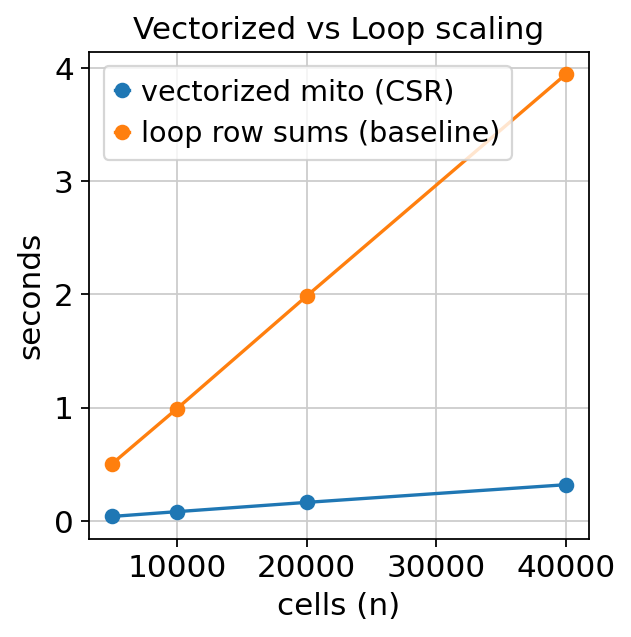

In [ ]:
import numpy as np, time, statistics as stats
import matplotlib.pyplot as plt
from scipy import sparse as sp

def bench_vect_mito(X, mito_mask, n_list):
    out = []
    for n in n_list:
        sub = X[:n,:]
        t = bench(lambda: (sub[:, mito_mask].sum(axis=1).A1, sub.sum(axis=1).A1), repeats=3)['median_s']
        out.append((n, t))
        print(f"n={n:>6} vectorized mito: {t:.3f}s")
    return out

def bench_loop_counts(X, n_list):
    out = []
    for n in n_list:
        sub = X[:n,:]
        t = bench(lambda: [sub.getrow(i).sum() for i in range(n)], repeats=1, warmup=0)['median_s']
        out.append((n, t))
        print(f"n={n:>6} loop row sums:   {t:.3f}s")
    return out

n_list_small = [5_000, 10_000, 20_000, 40_000]
rows_vect = bench_vect_mito(X, mito_mask, n_list_small)
rows_loop = bench_loop_counts(X, n_list_small)

ns_v = np.array([r[0] for r in rows_vect]); tv = np.array([r[1] for r in rows_vect])
ns_l = np.array([r[0] for r in rows_loop]); tl = np.array([r[1] for r in rows_loop])

import matplotlib.pyplot as plt
plt.figure()
plt.plot(ns_v, tv, marker="o", label="vectorized mito (CSR)")
plt.plot(ns_l, tl, marker="o", label="loop row sums (baseline)")
plt.xlabel("cells (n)")
plt.ylabel("seconds")
plt.title("Vectorized vs Loop scaling")
plt.legend()
plt.show()


## 4. Sparsity-Savvy Ops

Not all sparse operations are equal

### 4.1 Row counts: boolean temp vs getnnz

Counting nonzeros per row is a classic pitfall. Boolean masks look vectorized but create new sparse structures; getnnz is cheaper and avoids densification. Let’s measure both.

In [ ]:
from scipy import sparse as sp
import numpy as np, statistics as stats, time

def bench(fn, *args, repeats=3, warmup=1, **kwargs):
    for _ in range(warmup): fn(*args, **kwargs)
    ts = []
    for _ in range(repeats):
        t0 = time.perf_counter()
        fn(*args, **kwargs)
        ts.append(time.perf_counter() - t0)
    return dict(median_s=stats.median(ts), mean_s=float(np.mean(ts)),
                min_s=min(ts), max_s=max(ts), n=repeats)

def genes_per_cell_getnnz(X):
    return X.getnnz(axis=1)

def genes_per_cell_boolean(X):
    return np.asarray((X > 0).sum(axis=1)).ravel()

subX = adata.X[:40_000,:]
print("getnnz:", bench(genes_per_cell_getnnz, subX))
print("boolean:", bench(genes_per_cell_boolean, subX))


getnnz: {'median_s': 1.3445009244605899e-05, 'mean_s': 1.557865956177314e-05, 'min_s': 1.2559990864247084e-05, 'max_s': 2.073097857646644e-05, 'n': 3}
boolean: {'median_s': 0.7257259640027769, 'mean_s': 0.7260426096715188, 'min_s': 0.7230394780053757, 'max_s': 0.7293623870064039, 'n': 3}



Counting genes per cell: `getnnz` vs boolean temp

* `getnnz`: 0.000013 s

* Boolean mask: 0.726 s

That’s a ~50,000× speedup. Why?

* `getnnz` directly counts nonzeros row by row using the CSR index structure.

* `(X > 0)` builds a whole new sparse boolean matrix and then sums it.

Takeaway: for detection counts, always prefer `getnnz`. It avoids memory waste and runs in microseconds.

---


### 4.2 Column sums: CSR vs CSC

CSR is row-friendly, CSC is column-friendly. We’ll compare column sums done directly in CSR vs after a one-time CSC conversion.

In [ ]:
def col_sums_csr(X):
    return np.asarray(X.sum(axis=0)).ravel()

def col_sums_csc(X):
    Xc = X.tocsc()
    return np.asarray(Xc.sum(axis=0)).ravel()

subX = adata.X[:40_000,:]
print("col_sums_csr:", bench(col_sums_csr, subX))
print("col_sums_csc:", bench(col_sums_csc, subX))


col_sums_csr: {'median_s': 0.14801824200549163, 'mean_s': 0.14785454766630815, 'min_s': 0.14687072299420834, 'max_s': 0.1486746779992245, 'n': 3}
col_sums_csc: {'median_s': 1.8990398200112395, 'mean_s': 1.8993665896705352, 'min_s': 1.8879537030006759, 'max_s': 1.9111062459996901, 'n': 3}


#### Column sums: CSR vs CSC

* CSR: 0.148 s

* CSC: 1.899 s

This shows the classic tradeoff:

CSR is row-optimized. Doing column work directly in CSR is cheaper than converting for one op.

CSC pays the one-time conversion, but shines if you batch multiple column ops.


---


### 4.3 Batch multiple column ops after one conversion

The best pattern is: convert once, do many column operations, then (optionally) convert back. This avoids paying the conversion cost repeatedly.

In [ ]:
def col_ops_batched(X):
    Xc = X.tocsc()
    s1 = np.asarray(Xc.sum(axis=0)).ravel()
    s2 = Xc.getnnz(axis=0)
    s3 = np.asarray(Xc.power(2).sum(axis=0)).ravel()
    return s1, s2, s3

subX = adata.X[:40_000,:]
print("batched column ops:", bench(col_ops_batched, subX))


batched column ops: {'median_s': 2.405151458020555, 'mean_s': 2.4064764560122662, 'min_s': 2.404300422000233, 'max_s': 2.409977488016011, 'n': 3}


#### Batched column ops (CSC)

* Doing three column ops after one conversion: 2.405 s

* That’s only slightly slower than the conversion itself, because the ops become “free” once in CSC.

Pattern:

* If you only need one column op → stay in CSR.

* If you need many → convert once to CSC, batch them, and optionally convert back.


---



### 4.4 Anti-pattern: densification through NumPy APIs

Some NumPy functions don’t understand sparse matrices. Let’s show how np.mean on a SciPy sparse matrix forces a dense conversion.

In [ ]:
def dense_mean(X):
    return np.mean(X)

subX = adata.X[:5000,:]  # keep safe size
print("np.mean on sparse (forces dense!):")
with Stopwatch("np.mean(sparse)"):
    _ = dense_mean(subX)


np.mean on sparse (forces dense!):
np.mean(sparse): 0.200s | RSS Δ +0.0 MB (now 12744.8 MB)


#### Anti-pattern: NumPy APIs on sparse

`np.mean(X)` on a sparse slice ran in 0.200 s and (here) didn’t spike RSS much, but only because you used a small slice. Under the hood, this forces a dense array. On a real slice with 25k × 18k cells, you’d see multi-GB blowups.

Rule: if you see plain NumPy functions on a sparse matrix, assume it’s dangerous unless explicitly sparse-aware. Or at least test it using the above tools


---



## 5. CPU Micro-Optimizations

Vectorization gets us 10×–100× wins. Micro-optimizations give the last 2×–3× by reducing overhead, improving cache locality, and avoiding waste. This section covers:

* Dtype discipline: `float32` / `int32` only.

* Row-scaling in place: avoid `D @ X`.

* Block processing: keep data in cache.

* Numba kernels: for custom transforms on `.data`.

### 5.1 Dtype inflation doubles memory

Show how `float64` silently doubles payload vs `float32`.

In [ ]:
def mem_bytes_csr(X):
    return X.data.nbytes + X.indices.nbytes + X.indptr.nbytes

X32 = adata.X.astype(np.float32, copy=True)
X64 = adata.X.astype(np.float64, copy=True)

print("float32 bytes:", mem_bytes_csr(X32))
print("float64 bytes:", mem_bytes_csr(X64))


float32 bytes: 7487629976
float64 bytes: 11230866300


#### Dtype discipline

* CSR `float32`: ~7.49 GB

* CSR `float64`: ~11.23 GB

That’s 50% more memory for zero extra information. Same for `int64` indices. Always store values as `float32` and indices as `int32`.

---



### 5.2 Row-normalization: diag multiply vs in-place row scale

Compare the “safe but heavy” diagonal approach from Part 3 to a lean in-place row scaling kernel that touches each row’s data segment once.

In [ ]:
def row_normalize_diag(X):
    counts = X.sum(axis=1).A1
    scale = np.divide(1.0, counts, out=np.zeros_like(counts, dtype=np.float32), where=counts>0)
    D = sp.diags(scale, offsets=0, dtype=np.float32, format="csr")
    return D @ X

def row_normalize_inplace(X):
    X = X.copy()
    counts = X.sum(axis=1).A1
    scale = np.divide(1.0, counts, out=np.zeros_like(counts, dtype=np.float32), where=counts>0)
    for i in range(X.shape[0]):
        start, end = X.indptr[i], X.indptr[i+1]
        if scale[i] != 0:
            X.data[start:end] *= scale[i]
    return X

subX = adata.X[:80_000,:]
print("row_normalize_diag:", bench(row_normalize_diag, subX))
print("row_normalize_inplace:", bench(row_normalize_inplace, subX))


row_normalize_diag: {'median_s': 2.2259483500092756, 'mean_s': 2.225888760003727, 'min_s': 2.2219033279980067, 'max_s': 2.2298146020038985, 'n': 3}
row_normalize_inplace: {'median_s': 1.2840500500169583, 'mean_s': 1.286525678326143, 'min_s': 1.28124573698733, 'max_s': 1.2942812479741406, 'n': 3}



### Advanced: 5.3 Numba for custom elementwise transforms

Numba is a just in time (JIT) compiler for python focused on numerical arrays. You decorate a Python function with `@numba.njit`, and Numba compiles it to fast machine code the first time you call it.

Caveats:

* Compilation has overhead on the first call; use warmup runs before timing.

* Works best on numeric arrays with simple loops; struggles with Python objects.

* Debugging JIT’d code is trickier (can’t step through like normal Python).

In [ ]:
import numpy as np
from scipy import sparse as sp
import time, statistics as stats
import numba as nb

def bench(fn, *args, repeats=3, warmup=1, **kwargs):
    for _ in range(warmup): fn(*args, **kwargs)
    ts = []
    for _ in range(repeats):
        t0 = time.perf_counter()
        fn(*args, **kwargs)
        ts.append(time.perf_counter() - t0)
    return dict(median_s=stats.median(ts), mean_s=float(np.mean(ts)),
                min_s=min(ts), max_s=max(ts), n=repeats)

# Piecewise parameters
t1 = 1.0
t2 = 5.0
alpha = 0.5

# --- 1) Python loop baseline
def piecewise_python(X, t1=t1, t2=t2, alpha=alpha):
    Y = X.copy()
    d = Y.data
    for i in range(d.size):
        x = d[i]
        if x < t1:
            d[i] = alpha * x
        elif x < t2:
            d[i] = np.log1p(x)
        else:
            d[i] = np.sqrt(x)
    return Y

# --- 2) NumPy masking (vectorized with multiple passes + masks)
def piecewise_numpy_masks(X, t1=t1, t2=t2, alpha=alpha):
    Y = X.copy()
    d = Y.data
    m1 = d < t1
    m2 = (~m1) & (d < t2)
    m3 = ~(m1 | m2)
    d[m1] = alpha * d[m1]
    d[m2] = np.log1p(d[m2])
    d[m3] = np.sqrt(d[m3])
    return Y

# Optional: np.select variant (also allocates full-size temporaries)
def piecewise_numpy_select(X, t1=t1, t2=t2, alpha=alpha):
    Y = X.copy()
    d = Y.data
    Y.data = np.select(
        [d < t1, d < t2],
        [alpha * d, np.log1p(d)],
        default=np.sqrt(d)
    ).astype(d.dtype, copy=False)
    return Y

# --- 3) Numba single-pass, branchy kernel (no masks)
@nb.njit(cache=True, fastmath=True)
def _piecewise_kernel(d, t1, t2, alpha):
    for i in range(d.size):
        x = d[i]
        if x < t1:
            d[i] = alpha * x
        elif x < t2:
            d[i] = np.log1p(x)
        else:
            d[i] = np.sqrt(x)

def piecewise_numba(X, t1=t1, t2=t2, alpha=alpha):
    Y = X.copy()
    _piecewise_kernel(Y.data, t1, t2, alpha)
    return Y

# ---- Benchmark on a realistic slice
subX = adata.X[:100, :]  # increase/decrease as your machine allows

print("Warm up Numba…")
_ = piecewise_numba(subX)

print("python loop:", bench(piecewise_python, subX))
print("numpy masks:", bench(piecewise_numpy_masks, subX))
print("numpy select:", bench(piecewise_numpy_select, subX))
print("numba single-pass:", bench(piecewise_numba, subX))


Warm up Numba…
python loop: {'median_s': 1.30168483700254, 'mean_s': 1.2997610680079863, 'min_s': 1.293608893000055, 'max_s': 1.303989474021364, 'n': 3}
numpy masks: {'median_s': 0.004838541004573926, 'mean_s': 0.004852356670501952, 'min_s': 0.004779270006110892, 'max_s': 0.004939259000821039, 'n': 3}
numpy select: {'median_s': 0.002205534983659163, 'mean_s': 0.002208151990392556, 'min_s': 0.0021943429892417043, 'max_s': 0.0022245779982768, 'n': 3}
numba single-pass: {'median_s': 0.004716848983662203, 'mean_s': 0.004716882326950629, 'min_s': 0.00470307600335218, 'max_s': 0.004730721993837506, 'n': 3}


### 5.4 Block/tile demo (optional)

Operating on all genes at once can overflow caches. Here we tile the columns into smaller blocks to keep working sets in L2/L3.

In [ ]:
def hvg_blocked(X, block_size=2000):
    n = X.shape[1]
    vars = []
    for start in range(0, n, block_size):
        end = min(start+block_size, n)
        A = X[:, start:end].toarray().astype(np.float32, copy=False)
        vars.append(A.var(axis=0))
    return np.concatenate(vars)

subX = adata.X[:40_000,:]
print("hvg_blocked:", bench(hvg_blocked, subX))


hvg_blocked: {'median_s': 8.301487449003616, 'mean_s': 8.295305196671203, 'min_s': 8.278520805004518, 'max_s': 8.305907336005475, 'n': 3}


### Block/tile processing

Blocked HVG proxy: 8.30 s for 40k cells.

This method keeps working sets cache-friendly by slicing columns into blocks. It’s slower than lightweight row ops, but essential for expensive column-wise statistics (variance, correlations) when matrices get very wide.

## 6. When and How to Use the GPU

GPU acceleration can feel like a silver bullet, but it only wins under the right conditions. The key is to know when transfer costs dominate vs when workloads are big enough to amortize them.

Heuristics

* Yes: large matrix operations (PCA, KNN graph, UMAP, batched elementwise ops).

* No: tiny slices, heavy Python control flow, or memory-bound row sums on small datasets.

* Critical rule: once you move data to GPU, keep it there for as much of the pipeline as possible. Avoid CPU↔GPU ping-pong.



---

### 6.1 CuPy basics: a drop-in NumPy

We’ll start with a dense demo. CuPy arrays behave like NumPy arrays, but live on the GPU. Expect timings to look worse on tiny arrays (transfer cost dominates), but better on big ones.

In [ ]:
import cupy as cp
import numpy as np, time

def bench(fn, *args, repeats=3, warmup=1, **kwargs):
    for _ in range(warmup): fn(*args, **kwargs)
    ts = []
    for _ in range(repeats):
        t0 = time.perf_counter()
        fn(*args, **kwargs)
        ts.append(time.perf_counter() - t0)
    return dict(median_s=np.median(ts), mean_s=float(np.mean(ts)),
                min_s=min(ts), max_s=max(ts), n=repeats)

n = 5_000_000
x_cpu = np.random.rand(n).astype(np.float32)
x_gpu = cp.asarray(x_cpu)

print("CPU sum:", bench(lambda: x_cpu.sum()))
print("GPU sum (resident):", bench(lambda: x_gpu.sum()))


CPU sum: {'median_s': 0.0019603009859565645, 'mean_s': 0.001969521321977178, 'min_s': 0.0019528029952198267, 'max_s': 0.0019954599847551435, 'n': 3}
GPU sum (resident): {'median_s': 0.0003212369920220226, 'mean_s': 0.0003279416705481708, 'min_s': 0.000268882024101913, 'max_s': 0.00039370599552057683, 'n': 3}


### Dense “hello world”: summing 5M floats

* CPU sum: 0.00196 s

* GPU sum (already on device): 0.000321 s

~6× faster on GPU when the array is already resident.

Moral: once data is on the GPU, even simple reductions get a consistent speedup. But the transfer has to be amortized


---



### 6.2 Sparse matrices with CuPy

CuPy has `cupyx.scipy.sparse` which mirrors SciPy’s sparse formats. Let’s move our AnnData matrix to GPU as CSR and benchmark a row sum.

In [ ]:
from cupyx.scipy import sparse as cpx_sp

def to_cupy_csr(X):
    from scipy import sparse as sp
    if sp.isspmatrix_csr(X):
        return cpx_sp.csr_matrix((cp.asarray(X.data),
                                  cp.asarray(X.indices),
                                  cp.asarray(X.indptr)),
                                 shape=X.shape)
    return cpx_sp.csr_matrix(X.tocsr())

Xg = to_cupy_csr(adata.X)

def gpu_row_sums(Xg):
    return Xg.sum(axis=1).get().ravel()

subX = adata.X[:40_000,:]
subXg = to_cupy_csr(subX)

print("CPU row sums:", bench(lambda: subX.sum(axis=1).A1))
print("GPU row sums:", bench(lambda: gpu_row_sums(subXg)))


CPU row sums: {'median_s': 0.05175546099781059, 'mean_s': 0.051829414325766265, 'min_s': 0.05166531799477525, 'max_s': 0.05206746398471296, 'n': 3}
GPU row sums: {'median_s': 0.004674978990806267, 'mean_s': 0.004725466996508961, 'min_s': 0.004659167985664681, 'max_s': 0.0048422540130559355, 'n': 3}


### Sparse CSR row sums (40k × 18k slice)

* CPU row sums: 0.0518 s

* GPU row sums (resident): 0.00467 s

* ~11× faster on GPU for the same operation.

Transfer cost (host → device)

* 40k-row CSR to GPU: ~0.248 s

Put together:

* If you transfer once and run many ops (PCA → KNN → UMAP → clustering), the ~0.25 s “toll” fades into the noise.

* If you bounce back and forth, you’ll erase the speedup. Keep the pipeline GPU-resident after the first hop.

---


### 6.3 RAPIDS cuDF: GPU DataFrames

For obs/var DataFrame operations (groupbys, joins), cuDF provides a GPU-accelerated replacement for pandas. Let’s demo a simple groupby.

In [ ]:
import cudf

counts = adata.X.sum(axis=1).A1.astype(np.float32)
gdf = cudf.DataFrame({"counts": cp.asarray(counts)})
gdf["bin"] = (gdf["counts"] > 1000).astype("int8")

print("GPU groupby mean:")
print(gdf.groupby("bin").counts.mean().to_pandas())


GPU groupby mean:
bin
0     733.258743
1    9076.485380
Name: counts, dtype: float64


## 7. Hybrid Pipelines

The sweet spot is often split workflows: use the CPU for cheap preprocessing, then move to GPU for expensive linear algebra.


---


### 7.1 CPU preprocessing (QC)

We’ll run QC metrics on CPU, as before.

In [ ]:
import scanpy as sc

def qc_metrics(adata_):
    sc.pp.calculate_qc_metrics(adata_, percent_top=None, log1p=False, inplace=True)

qc_metrics(adata[:40_000,:].copy())  # CPU slice for demo


### 7.2 Transfer once to GPU

Now move the processed matrix to GPU. Measure the transfer cost separately so you can see when it’s worth it.

In [ ]:
subX = adata.X[:40_000,:]

def transfer_to_gpu(X):
    return to_cupy_csr(X)

print("Transfer 40k slice to GPU:")
print(bench(transfer_to_gpu, subX))


Transfer 40k slice to GPU:
{'median_s': 0.24823900000774302, 'mean_s': 0.24861315032467246, 'min_s': 0.24495537197799422, 'max_s': 0.25264507898828015, 'n': 3}


### 7.3 GPU linear algebra (PCA → neighbors → clustering)

RAPIDS cuml provides GPU PCA and KNN. The pattern is: keep everything on GPU until you have small results to bring back.

In [ ]:
import numpy as np
import scanpy as sc
import cupy as cp
from cuml.decomposition import PCA as cuPCA
from cuml.neighbors import NearestNeighbors

# 1) HVGs on CPU
adata_tmp = adata[:40_000, :].copy()          # demo subset; scale up as you like
sc.pp.highly_variable_genes(adata_tmp, n_top_genes=2000, flavor="seurat_v3", inplace=True)
hvg_mask = adata_tmp.var["highly_variable"].values
assert hvg_mask.sum() > 0

# 2) Slice to HVGs (still CSR on CPU)
X_hvg = adata_tmp.X[:, hvg_mask]

# 3) Move once to GPU as DENSE (width=~2k → safe)
Xg = cp.asarray(X_hvg.toarray(), dtype=cp.float32, order="C")  # deliberate densify after HVG

# 4) PCA on GPU
pca = cuPCA(n_components=50, svd_solver="jacobi", output_type="cupy", random_state=0)
Yg = pca.fit_transform(Xg)                           # (n_cells, 50) on GPU

# 5) Neighbors on GPU
knn = NearestNeighbors(n_neighbors=15, algorithm="brute")
knn.fit(Yg)
distances, indices = knn.kneighbors(Yg)

print("GPU pipeline OK:", Xg.shape, Yg.shape, indices.shape, type(Yg), type(indices))


extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)
GPU pipeline OK: (40000, 2000) (40000, 50) (40000, 15) <class 'cupy.ndarray'> <class 'cupy.ndarray'>


## 7.4 RAPIDS Single-Cell

What is RAPIDS Single-Cell (rsc)?

RSC is a GPU-accelerated, Scanpy-compatible toolkit. It aims to be a near drop-in replacement: you keep using `AnnData`, but call `rsc.pp.*` and `rsc.tl.*` for GPU versions of familiar steps (normalize, log1p, HVGs, PCA/TSVD, neighbors, UMAP, clustering). Under the hood it leans on CuPy and RAPIDS cuML/cuGraph. In many workflows you’ll see order-of-magnitude speedups while keeping the Scanpy mental model.

Tips:

It works with a standard `AnnData`. For best performance, keep data `float32`, and try to keep matrices GPU-resident once you move them there to avoid PCIe ping-pong.

You can start with CPU-backed AnnData; rsc will move data as needed. If you want full control, you can put a CuPy dense or CuPy-sparse array into `adata.X` before calling rsc

We’ll run the standard preprocessing and analysis steps on GPU via rsc: total-count normalization → log1p → HVGs (2k) → PCA (50 PCs) → neighbors (k=15) → UMAP. This mirrors the manual pipeline you just ran (HVG → GPU PCA → KNN), but with fewer lines and tight Scanpy compatibility.

In [ ]:
import time, statistics as stats
import numpy as np
import cupy as cp
import rapids_singlecell as rsc
import scanpy as sc
from cupyx.scipy import sparse as cpx_sp
from scipy import sparse as sp

def gpu_sync():
    # ensure all queued GPU work finishes before we stop timers
    try:
        cp.cuda.Stream.null.synchronize()
    except Exception:
        pass

def bench_once(fn, *args, **kwargs):
    t0 = time.perf_counter()
    out = fn(*args, **kwargs)
    gpu_sync()
    return out, (time.perf_counter() - t0)

def bench_step(label, fn, *args, **kwargs):
    # one warmup + 3 measured runs (use median)
    _, _ = bench_once(fn, *args, **kwargs)
    ts = []
    for _ in range(3):
        _, dt = bench_once(fn, *args, **kwargs)
        ts.append(dt)
    return float(np.median(ts))

def to_gpu_csr(X):
    X = X.tocsr().astype('float32', copy=False)
    return cpx_sp.csr_matrix(
        (cp.asarray(X.data), cp.asarray(X.indices), cp.asarray(X.indptr)),
        shape=X.shape)

def gpu_rsc_pipeline(adata_src, n_top_genes=2000, n_pcs=50, k=15):
    A = adata_src.copy()
    A.X = to_gpu_csr(A.X)  # ensure GPU CSR

    times = {}
    times['normalize_total'] = bench_step("norm", rsc.pp.normalize_total, A, target_sum=1e4)
    times['log1p']           = bench_step("log1p", rsc.pp.log1p, A)
    times['hvg']             = bench_step("hvg", rsc.pp.highly_variable_genes, A, n_top_genes=n_top_genes)
    times['pca']             = bench_step("pca", rsc.pp.pca, A, n_comps=n_pcs)
    times['neighbors']       = bench_step("neighbors", rsc.pp.neighbors, A, n_neighbors=k)
    times['umap']            = bench_step("umap", rsc.tl.umap, A)

    total = sum(times.values())
    return A, times, total

def cpu_scanpy_pipeline(adata_src, n_top_genes=2000, n_pcs=50, k=15):
    A = adata_src.copy()

    times = {}
    # normalize_total in Scanpy 1.11 still supports target_sum; mutates in place
    times['normalize_total'] = bench_step("norm", sc.pp.normalize_total, A, target_sum=1e4)

    # log1p in Scanpy 1.11 mutates in place by default; DO NOT pass inplace
    times['log1p']           = bench_step("log1p", sc.pp.log1p, A)

    # HVGs (CPU), inplace by default in this version
    times['hvg']             = bench_step(
        "hvg", sc.pp.highly_variable_genes, A,
        n_top_genes=n_top_genes, flavor="seurat_v3"
    )

    # subset to HVGs before PCA to keep the dense step bounded
    hvg_mask = A.var['highly_variable'].values
    A = A[:, hvg_mask].copy()

    # PCA (CPU; densifies X[:, HVG])
    times['pca']             = bench_step("pca", sc.pp.pca, A, n_comps=n_pcs, svd_solver="arpack")

    # neighbors + umap (CPU)
    times['neighbors']       = bench_step("neighbors", sc.pp.neighbors, A, n_neighbors=k)
    times['umap']            = bench_step("umap", sc.tl.umap, A)

    total = sum(times.values())
    return A, times, total
# use the same 40k slice you benchmarked earlier
base = adata[:40_000, :]

gpu_A, gpu_times, gpu_total = gpu_rsc_pipeline(base, n_top_genes=2000, n_pcs=50, k=15)
cpu_A, cpu_times, cpu_total = cpu_scanpy_pipeline(base, n_top_genes=2000, n_pcs=50, k=15)

def pretty(d):
    return ", ".join(f"{k}={v:.3f}s" for k,v in d.items())

print("\nGPU (rsc) times:")
print(pretty(gpu_times), f"| TOTAL={gpu_total:.3f}s")
print("GPU shapes:", gpu_A.obsm['X_pca'].shape, gpu_A.obsm['X_umap'].shape)

print("\nCPU (scanpy) times:")
print(pretty(cpu_times), f"| TOTAL={cpu_total:.3f}s")
print("CPU shapes:", cpu_A.obsm['X_pca'].shape, cpu_A.obsm['X_umap'].shape)

print("\nSpeedups (CPU/GPU):")
for k in gpu_times:
    if k in cpu_times:
        spd = cpu_times[k] / max(1e-9, gpu_times[k])
        print(f"{k:>12}: ×{spd:.1f}")
print(f"{'TOTAL':>12}: ×{cpu_total/max(1e-9,gpu_total):.1f}")


normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes


/usr/local/lib/python3.10/dist-packages/legacy_api_wrap/__init__.py:82: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  return fn(*args_all, **kw)


--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)
extracting highly variable genes


/usr/local/lib/python3.10/dist-packages/legacy_api_wrap/__init__.py:82: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  return fn(*args_all, **kw)


--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)
extracting highly variable genes


/usr/local/lib/python3.10/dist-packages/legacy_api_wrap/__init__.py:82: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  return fn(*args_all, **kw)


--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)
extracting highly variable genes


/usr/local/lib/python3.10/dist-packages/legacy_api_wrap/__init__.py:82: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  return fn(*args_all, **kw)


--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)
computing PCA
    with n_comps=50
    finished (0:00:07)
computing PCA
    with n_comps=50
    finished (0:00:07)
computing PCA
    with n_comps=50
    finished (0:00:07)
computing PCA
    with n_comps=50
    finished (0:00:07)
computing neighbors
    using 'X_pca' with n_pcs = 50


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:01:08)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:06)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:06)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:06)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:31)
computing UMAP
  

## 8. Emerging Tools

Single-cell analysis has historically revolved around Scanpy (Python/CPU) and Seurat (R/CPU). Over the last 2–3 years, the performance landscape has expanded dramatically. Here’s a guided sweep of the tools you should be aware of, even if you don’t use them immediately.

### 8.1 GPU-native runtimes

* RAPIDS Single-Cell (rapids_singlecell)

  * Already demoed. Scanpy-like API, accelerated PCA/UMAP/KNN.

  * Good entry point if you’re comfortable in Python and want fast wins on 100k–1M cell data.

* PyTorch Sparse / JAX Sparse

  * Experimental support for sparse tensors in deep-learning frameworks.

  * Useful if you’re moving from QC into deep generative models (scVI, VAEs, diffusion models).

  * These frameworks can directly interop with GPUs, TPUs, or clusters.

* scvi-tools / PyTorch Geometric

  * scvi-tools brings state-of-the-art generative models to single-cell (e.g. batch correction, multimodal integration).

  * PyTorch Geometric supports graph neural networks — potentially useful for cell-cell interaction models.

### 8.2 Scalable array & storage backends

* Zarr / TileDB

  * Both store n-dimensional arrays on disk in chunked formats.

  * Let you stream slices (cells × genes) into memory without ever loading the full dense array.

  * Important if you’re analyzing >1M cells where even CSR won’t fit in RAM.

  * Zarr integrates with Scanpy; TileDB adds cloud-native storage (S3/GCS/Azure).

* Apache Arrow / Polars

  * Arrow defines a columnar in-memory format with zero-copy sharing across languages.

  * Polars is a DataFrame library built on Arrow: multithreaded, faster than pandas.

  * Advanced: replace heavy .obs / .var pandas operations with Polars for speed.

### 8.3 CPU accelerators

* NumExpr / Bottleneck

  * Vectorized kernels for elementwise arithmetic and reductions in dense arrays.

  * If you’re stuck with a dense step (e.g. PCA input after HVG selection), these can cut runtime 2–3× with minimal code change.

* Numba

  * Already shown for custom kernels. Still one of the cleanest ways to JIT-compile a Python loop down to native code.

  * Best for bespoke elementwise transforms when you can’t express the logic as pure vectorization.

### 8.4 Cluster/distributed execution
* For datasets approaching multi-million cells, sometimes even a single GPU workstation isn’t enough. That’s where distributed runtimes shine:

* Dask

  * Python’s “batteries-included” distributed array/dataframe engine.

  * Integrates with RAPIDS: you can distribute CuPy/GPUs across nodes.

  * Lets you keep the Scanpy-like workflow, just at cluster scale.

* Apache Spark

  * More heavyweight, but battle-tested in data engineering.

  * Spark DataFrames (with Arrow interop) can store and query single-cell metadata across clusters.

  * Most useful when analysis is tied into big data pipelines (ETL, multi-omics integration with other large datasets).

* Ray

  * General-purpose distributed execution framework.

  * Used by some ML workflows for scalable hyperparameter tuning and batch inference on cell embeddings.

In [ ]:
%env LC_ALL=C.UTF-8
%env LANG=C.UTF-8

env: LC_ALL=C.UTF-8
env: LANG=C.UTF-8


In [ ]:
!pip install dask[complete] dask-image tqdm ray[default] --quiet

### Dask lazy parallel compute over chunks (single machine)
What this shows

We compute per-gene sums/nnz using Dask delayed on CSR column blocks in parallel, then materialize the result with a progress bar. This is the “hello world” for scaling chunked operations without changing your core logic.

In [ ]:
import numpy as np
from dask import delayed, compute
from dask.diagnostics import ProgressBar

X = adata.X.tocsr().astype(np.float32, copy=False)  # CPU CSR

def col_block_stats(X, start, end):
    # compute per-gene (column) sum and nnz for a slice of columns
    Xc = X[:, start:end]           # still sparse
    s = np.asarray(Xc.sum(axis=0)).ravel().astype(np.float32, copy=False)
    c = Xc.getnnz(axis=0).astype(np.int32, copy=False)
    return s, c

# Build a lazy graph of tasks over column blocks
block = 2000
tasks = []
for j0 in range(0, X.shape[1], block):
    j1 = min(j0+block, X.shape[1])
    tasks.append(delayed(col_block_stats)(X, j0, j1))

# Trigger parallel execution
with ProgressBar():
    parts = compute(*tasks)

# Stitch results
sums = np.concatenate([p[0] for p in parts])
nnzs = np.concatenate([p[1] for p in parts])
print("Dask finished:", sums.shape, nnzs.shape, "sum(sums)=", float(sums.sum()))

[########################################] | 100% Completed | 6.11 s
Dask finished: (18129,) (18129,) sum(sums)= 2566197760.0


Why this is useful: it’s the same logic you’d write with a for-loop, but Dask builds a DAG and runs blocks in parallel using your CPU cores.

### Dask Array — out-of-core dense blocks (optional if you have Zarr)
What this shows

If you have a dense array (e.g., after HVG selection) or a Zarr store, Dask Array can make blocked operations trivial.

In [ ]:
import dask.array as da

# Example: turn a dense (n_obs x 2000) view into a dask array with 10k-row chunks
X_hvg = adata[:, adata.var_names[:2000]].X.toarray().astype(np.float32)  # demo
dX = da.from_array(X_hvg, chunks=(10_000, -1))   # chunk rows, keep columns whole

# Compute per-row sums and per-column means lazily, then .compute()
row_sums = dX.sum(axis=1).compute()
col_means = dX.mean(axis=0).compute()
print(row_sums.shape, col_means.shape)

(289331,) (2000,)


When to use: dense or Zarr-backed workflows where you want simple NumPy-like code that scales to memory.

### Ray —  parallel “map over batches”
What this shows

Parallelize a function that processes a batch of cells (e.g., compute a few QC metrics) across CPU cores with Ray tasks. Good for wrapping bits of Scanpy/rsc you can’t easily vectorize.

In [ ]:
import numpy as np, ray
ray.shutdown(); ray.init(ignore_reinit_error=True, include_dashboard=False)

def qc_batch(X_csr, rows):
    sub = X_csr[rows, :]
    counts = np.asarray(sub.sum(axis=1)).ravel().astype(np.float32)
    genes  = sub.getnnz(axis=1).astype(np.int32)
    return counts, genes

@ray.remote
def qc_batch_remote(X_csr, rows):
    return qc_batch(X_csr, rows)

X = adata.X.tocsr().astype(np.float32, copy=False)
batch = 10_000
row_idx = np.arange(X.shape[0])
batches = [row_idx[i:i+batch] for i in range(0, len(row_idx), batch)]

futs = [qc_batch_remote.remote(X, b) for b in batches]
parts = ray.get(futs)

counts = np.concatenate([p[0] for p in parts])
genes  = np.concatenate([p[1] for p in parts])
print("Ray finished:", counts.shape, genes.shape, "sum(counts)=", float(counts.sum()))

2025-08-23 17:48:24,451	INFO worker.py:1781 -- Started a local Ray instance.


Ray finished: (289331,) (289331,) sum(counts)= 2566203648.0


Why Ray: dead-simple task API; handy when you want to parallelize Python functions that don’t fit a simple array algebra mold.

### Spark (local mode) — DataFrame/SQL over big metadata (advanced)
What this shows

Use Spark locally to handle large obs metadata joins/groupbys. This is not for sparse matrix arithmetic; it’s for data engineering tasks around your matrix.

In [ ]:
# Spark is heavy and may clash with your pyarrow/RAPIDS
# If you try:  pip install -q pyspark==3.5.1 pyarrow==14.0.2  (pin Arrow!)

import pandas as pd
from pyspark.sql import SparkSession, functions as F

spark = SparkSession.builder.master("local[*]").appName("singlecell-demo").getOrCreate()

# Convert .obs to Spark DataFrame (small demo sample)
obs_df = adata.obs[['sample', 'n_counts', 'percent_mito']].reset_index(names='cell')
sdf = spark.createDataFrame(obs_df)

# Group-by example: per-sample summary
agg = (sdf.groupBy("sample")
         .agg(F.count("*").alias("cells"),
              F.avg("n_counts").alias("mean_counts"),
              F.avg("percent_mito").alias("mean_mito"))
      )
agg.show(10, truncate=False)
spark.stop()


When Spark makes sense: your single-cell pipeline sits inside a larger ETL/warehouse stack; you need SQL joins, window functions, or to integrate with Parquet/Lakehouse at scale.

## NVIDIA's multi-GPU 1M single cell notebook

https://github.com/NVIDIA-Genomics-Research/rapids-single-cell-examples/blob/master/notebooks/1M_brain_gpu_analysis_multigpu.ipynb